# Homework 3: Reproducibility in Climate Studies

* **Statistics 159/259, Spring 2022**
* **Due 03/23/2023, 23:59PM PT**
* Prof. F. Pérez and GSI F. Sapienza, Department of Statistics, UC Berkeley.
* This assignment is worth a maximum of **50 points**.
* Assignment type: **group homework assignment** (Check on Ed Discussion about group's assignments).

## 2. The West Coast Heat Wave

In 2016 [Dr. Chelle Gentemann](https://cgentemann.github.io) and collaborators published a [paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2016GL071039) on the heat wave in the ocean off the California coast

The analysis was then performed using Matlab to process scientific data. To make Figure 1, here are the following steps:
- Download 4 TB of data from NASA PO.DAAC data archive via FTP
- Go through each day of data and subset to the West Coast Region to reduce size and save each subsetted day
- Go through 2002-2012 and create a daily climatology and save all 365 days of the climatology
- Go through each day of data and calculate the anomaly and save each day's anomaly

This whole process took about 1-2 month. 
Below we will do this using MUR SST data on AWS Open Data Program in a few minutes using Python.

### Question 4 [10 points]

Reproduce Figure 1 in the paper. When doing that, try to slice data using `xarray` in the most clear and reproducible way (for example, don't use indices to access data objects like we did in the example above).

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import datetime

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from pathlib import Path

# Small style adjustments for more readable plots
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

Subset all the data to just the West Coast region

In [3]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")
ds

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 251, lon: 234)
Coordinates:
  * lat               (lat) float32 33.0 33.06 33.12 33.18 ... 47.88 47.94 48.0
  * lon               (lon) float32 -132.0 -131.9 -131.9 ... -118.1 -118.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

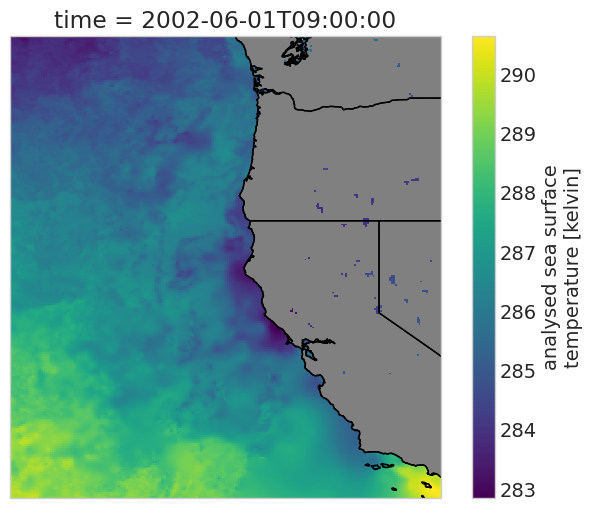

In [4]:
ds.analysed_sst[0, :, :].plot()

# Plot on a map
ax = plt.subplot(projection=crs)
ds.analysed_sst[0, :, :].plot(ax=ax, transform=crs)
ax.coastlines("10m", color="k")
ax.add_feature(cfeature.LAND, color="grey")
ax.add_feature(cfeature.STATES.with_scale("10m"))

### Q4 work start here

In [5]:
#change into Celcius
ds['analysed_sst'] = ds.analysed_sst - 273.15

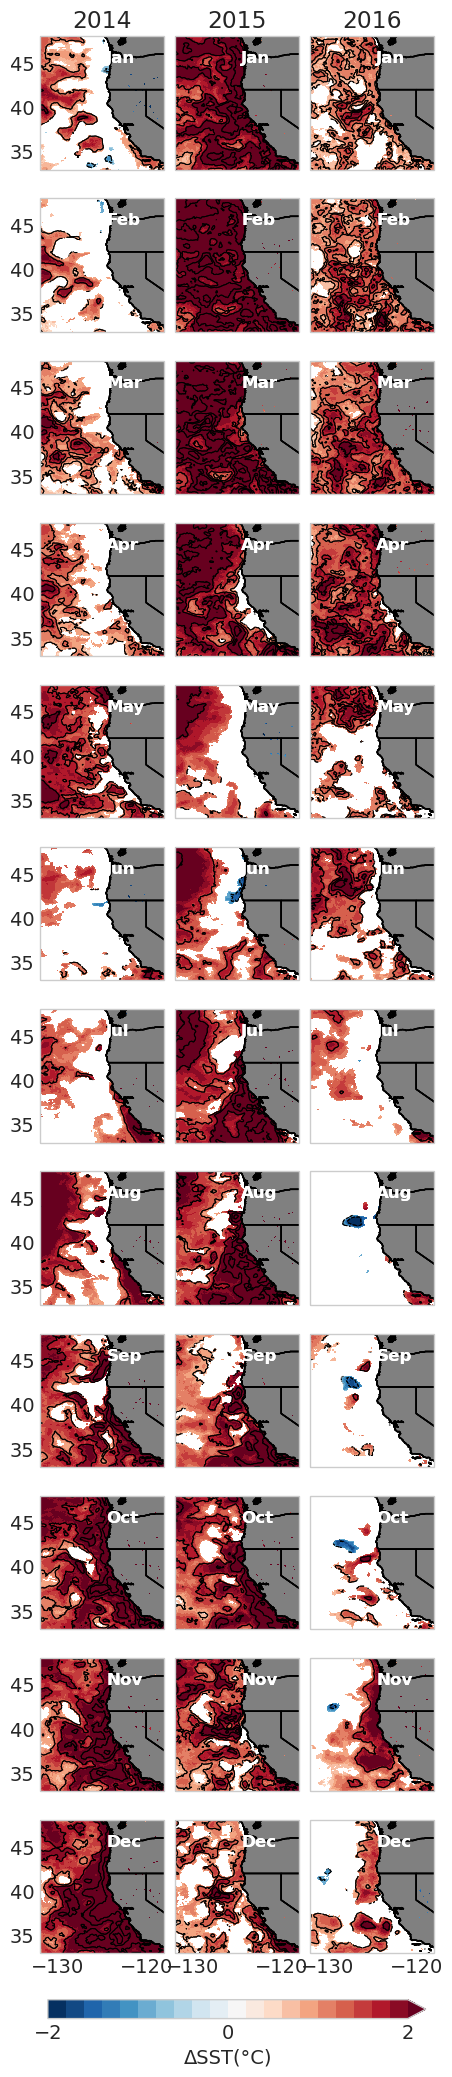

In [41]:
# Get data from 2002 to 2012, calculate mean and standard deviation
ds_prev = ds['analysed_sst'].sel(time=slice('2002', '2012'))
ds_prev_mean = ds_prev.groupby(ds_prev.time.dt.month).mean()
ds_prev_sd = ds_prev.groupby(ds_prev.time.dt.month).std()

# Get data for 2014, 2015, and 2016, calculate mean for each year
years = [2014, 2015, 2016]
ds_yearly_mean = {year: ds['analysed_sst'].sel(time=slice(f"{year}-01-01", f"{year}-12-31")).groupby("time.month").mean() for year in years}

# Calculate anomalies for each year
anomalies = {year: (ds_yearly_mean[year] - ds_prev_mean).where(abs(ds_yearly_mean[year] - ds_prev_mean) / ds_prev_sd >= 1) for year in years}

# Month list for text labels
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Define the color map and levels
cmap = plt.get_cmap("RdBu_r")
levels = np.linspace(-2, 2, 21)

# Set up the plot
fig, axs = plt.subplots(nrows=12, ncols=3, sharex=True, sharey=True, subplot_kw=dict(projection=crs), figsize=(6, 30), facecolor='white')
num_months = len(months)
# Define the color map and levels
def draw_anomaly(data, y, year):
    for m in range(num_months):
        # Plot the data
        plot = data.sel(month=m+1).plot(col_wrap=3, ax=axs[m, y], transform=crs, vmin=-3, vmax=3, cmap=cmap, levels=levels, add_colorbar=False)
        data.sel(month=m+1).plot.contour(ax=axs[m, y], colors='black', linewidths=0.7, cmin=-3, cmax=3)
        axs[m, y].add_feature(cfeature.LAND, color="grey")
        axs[m, y].add_feature(cfeature.STATES.with_scale("10m"))
        axs[m, y].coastlines("10m", color="k")
        axs[m, y].set_title("")

        # Add labels
        axs[m, y].text(-124.5, 45, months[m], fontsize=12, color="white", fontweight="semibold")
        axs[m, y].set(xlabel=None, ylabel=None)

        # Set ticks
        if m == 0:
            axs[m, y].set_title(year)
        if year == 2014:
            axs[m, y].set_yticks([35, 40, 45])
        if m == 11:
            axs[m, y].set_xticks([-130, -120])
    return plot

# Draw anomalies for 2014, 2015, and 2016
for y, year in enumerate(years):
    draw_anomaly(anomalies[year], y, year)

# Draw anomalies for 2014, 2015, and 2016
for y, year in enumerate(years):
    plot = draw_anomaly(anomalies[year], y, year)
    
# Adjust subplot spacing
fig.subplots_adjust(left=0, hspace=.215, wspace=-.50)

# Add colorbar
cbar = plt.colorbar(plot, ax = axs, location = 'bottom', ticks=np.arange(-2, 3, 2), shrink = 0.7, pad = 0.02)
cbar.set_label('ΔSST(°C)', loc="center")
plt.savefig('Q4')
plt.show()